# Read data from the drive

If needed, mount your drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Read the data from the directory 'dir'. \\
An assumption is that the images file names are in the format: 'baza-label-num.bmp'.

Letter: A ...
Letter: E ...
Letter: I ...
Letter: O ...
Letter: U ...



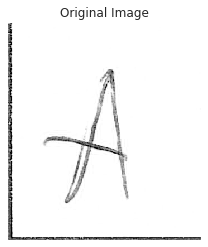

In [0]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
n_examples = 120
dir = '...'
letters = ['A', 'E', 'I', 'O', 'U']

def show_image(img, title=None):
  plt.xticks([])
  plt.yticks([])
  plt.title(title)
  plt.imshow(X[0], 'gray')
  print()

def read_data():
    X = []
    y = np.repeat([0, 1, 2, 3, 4], n_examples)

    for letter in letters:
        print('Letter: {} ...'.format(letter))
        for img_num in range(1, n_examples+1):
            path = '{}/baza{}{}{}{}.bmp'.format(
                dir, letter, img_num // 100, (img_num % 100) // 10, img_num % 10
            )

            img = cv2.imread(path)
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            X.append(gray_image)
    return X, y

X, y = read_data()
show_image(X[0], 'Original Image')

# Preprocess every image

The preprocessing is done in the following way:


* Image is segmented with an empirical estimated threshold 
* Image is inverted, so that letter is white and background is black
* Border is removed, since it's not important for the classification
* Small components are also removed, so they don't affect further classification
* Only important part of an image is cropped, so it contains only the letter



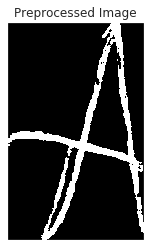

In [0]:
from skimage import filters
from queue import Queue 
from skimage import morphology

def bfs(img, visited, i_start, j_start):
  q = Queue(maxsize = 500)
  q.put([i_start, j_start])
  img[i_start, j_start] = 0 
  visited[i_start, j_start] = True

  while not q.empty():
    [i_curr, j_curr] = q.get()
    dij = [-1, 0, 1]

    for di in dij:
      i_next = i_curr + di
      if i_next < 0 or i_next >= img.shape[0]:
        continue
      for dj in dij:
        j_next = j_curr + dj
        if j_next < 0 or j_next >= img.shape[1]:
          continue
        if (i_next > 40 and i_next < img.shape[0] - 40) and (
            j_next > 40 and j_next < img.shape[1] - 40):
          continue

        if img[i_next, j_next] == 255 and not visited[i_next, j_next]:
          img[i_next, j_next] = 0 
          visited[i_next, j_next] = True
          q.put([i_next, j_next])
  return img, visited

def remove_white_edges(img):
  visited = np.zeros(shape=img.shape, dtype=bool)
  for i in [0, img.shape[0] - 1]:
    for j in range(img.shape[1]):
      if not visited[i, j] and img[i, j] == 255:
        img, visited = bfs(img, visited, i, j)
  for i in range(img.shape[0]):
    for j in [0, img.shape[1] - 1]:
      if not visited[i, j] and img[i, j] == 255:
        img, visited = bfs(img, visited, i, j)

    return img

def remove_very_small_components(img):
  nb_components, output, stats, centroids = (
      cv2.connectedComponentsWithStats(img, connectivity=8)
  )
  sizes = stats[1:, -1]; nb_components = nb_components - 1

  min_size = 20 # of a component
  img_2 = np.zeros((img.shape), dtype=int)
  for i in range(0, nb_components):
    if sizes[i] >= min_size:
      img_2[output == i + 1] = 255
  return img_2

def get_relevant_part(img):
  (h, w) = img.shape

  # JMIN
  jmin = 0
  found = False
  for j in range(w):
    for i in range(h):
      if img[i, j] == 255:
        found = True
        jmin = j
      if found:
        break
    if found:
      break

  # JMAX
  jmax = 0
  found = False
  for j in reversed(range(w)):
    for i in range(h):
      if img[i, j] == 255:
        found = True
        jmax = j
      if found:
        break
    if found:
      break

  # IMIN
  imin = 0
  found = False
  for i in range(h):
    for j in range(w):
      if img[i, j] == 255:
        found = True
        imin = i
      if found:
        break
    if found:
      break

  # IMAX
  imax = 0
  found = False
  for i in reversed(range(h)):
    for j in range(w):
      if img[i, j] == 255:
        found = True
        imax = i
      if found:
        break
    if found:
      break

  return img[imin:imax, jmin:jmax]

def preprocess_image(img, img_num, label):
  print('Processing image {} of label {}...'.format(img_num, label))

  # Segmentation & inverse
  _, img = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
  img = 255 - img

  # No border and small componenets
  img = remove_white_edges(img)
  img = remove_very_small_components(img)

  # Crop image to have only letter
  img = get_relevant_part(img)

  return img

def preprocess_data(X):
  for img_num in range(len(X)):
    img = X[img_num]
    label = y[img_num]
    X[img_num] = preprocess_image(img, np.mod(img_num, n_examples), label)
  
  return X

X_p = preprocess_data(X)
show_image(X_p[0], 'Preprocessed Image')

# Save processed images

Save all the processed images to the directory 'dir_to_write', in the format 'label-num.bmp'.

In [0]:
dir_to_write = '...'

def save_preprocessed(X, y):
  for img_num in range(len(X)):
    img = X[img_num]
    label = y[img_num]

    img_label_num = np.mod(img_num, n_examples)
    a = cv2.imwrite('{}/{}-{}.bmp'.format(dir_to_write, label, img_label_num), img)
    
save_preprocessed(X_p, y)